In [1]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.9 MB/s eta 0:00:00


In [2]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta

# --- 2. Initialize ---
num_customers = 10000
np.random.seed(42)  # Changed seed for different results
fake = Faker()

# --- 3. Generate Base Customer Data (CRM System) ---
print("1. Generating Base CRM Data...")
customer_data = []
for i in range(num_customers):
    customer_data.append({
        'customer_id': f'C{i:05d}',
        'age': np.random.randint(18, 71),
        'gender': np.random.choice(['Male', 'Female', 'Non-binary'], p=[0.48, 0.48, 0.04]),
        'location': fake.city(),
        'acquisition_channel': np.random.choice(['Organic', 'Paid Search', 'Social Media', 'Referral'], p=[0.4, 0.3, 0.2, 0.1]),
        'tenure_months': np.random.randint(1, 61),
    })
customers_df = pd.DataFrame(customer_data)
# Add loyalty status based on tenure (more tenured customers are more likely to be members)
customers_df['loyalty_program_member'] = (customers_df['tenure_months'] > 12) & (np.random.rand(num_customers) > 0.4)

# --- 4. Generate Transactional Data (POS System) ---
print("2. Generating Transactional Data...")
transactions_list = []
end_date = datetime.now()
for _, row in customers_df.iterrows():
    # Each customer has between 1 and 50 transactions
    num_transactions = np.random.randint(1, 50)
    # Transactions occur over the customer's tenure
    customer_start_date = end_date - timedelta(days=row['tenure_months'] * 30)
    for _ in range(num_transactions):
        # Transaction date is random within their tenure
        trans_date = fake.date_time_between(start_date=customer_start_date, end_date=end_date)
        transactions_list.append({
            'customer_id': row['customer_id'],
            'transaction_date': trans_date,
            'transaction_amount': np.random.lognormal(mean=4, sigma=0.5), # More realistic spend distribution
            'discount_applied': np.random.rand() > 0.8 # 20% of transactions have a discount
        })
transactions_df = pd.DataFrame(transactions_list)

# --- 5. Generate Website & Support Data ---
print("3. Generating Website Interaction & Support Data...")
# This is simplified for demonstration. In reality, this could be another large log file.
customers_df['support_calls'] = np.random.poisson(lam=1.5, size=num_customers) # Poisson is better for count data
customers_df['sessions_last_30_days'] = np.random.poisson(lam=5, size=num_customers)
customers_df['pages_viewed_last_30_days'] = customers_df['sessions_last_30_days'] * np.random.uniform(1.5, 8, size=num_customers)
# Simulating cart abandonment
customers_df['cart_abandoned'] = (customers_df['sessions_last_30_days'] > 2) & (np.random.rand(num_customers) > 0.5)

# --- 6. Aggregate Data into a 360-Degree View ---
# This step simulates the data engineering work that Company X needs to do.
print("4. Aggregating data into 360-degree view...")

# Calculate Recency, Frequency, Monetary (RFM) from transactions
agg_transactions = transactions_df.groupby('customer_id').agg(
    recency_days=('transaction_date', lambda date: (end_date - date.max()).days),
    purchase_frequency=('transaction_date', 'count'),
    total_spend=('transaction_amount', 'sum'),
    avg_transaction_value=('transaction_amount', 'mean')
).reset_index()

# Merge the aggregated data back to the main customer dataframe
final_df = pd.merge(customers_df, agg_transactions, on='customer_id', how='left')

# Fill NaNs for customers who might not have transactions (though our script gives everyone at least one)
final_df.fillna({'recency_days': 999, 'purchase_frequency': 0, 'total_spend': 0, 'avg_transaction_value': 0}, inplace=True)


# --- 7. Apply Enhanced Business Logic to Create Churn ---
print("5. Calculating Churn based on enhanced features...")
churn_probability = np.zeros(num_customers)

# Rule 1: High recency -> higher churn probability
churn_probability += (final_df['recency_days'] / 365) * 0.3

# Rule 2: Low frequency -> higher churn probability
churn_probability[final_df['purchase_frequency'] < 5] += 0.15

# Rule 3: High support calls -> higher churn probability
churn_probability[final_df['support_calls'] > 3] += 0.2

# Rule 4: Loyalty members -> lower churn probability
churn_probability[final_df['loyalty_program_member'] == True] -= 0.25

# Rule 5: Cart abandonment -> higher churn probability
churn_probability[final_df['cart_abandoned'] == True] += 0.2

# Rule 6: High tenure -> lower churn probability (less impact now)
churn_probability -= (final_df['tenure_months'] / 60) * 0.1

# Add random noise and clip
churn_probability += np.random.normal(0, 0.1, num_customers)
churn_probability = np.clip(churn_probability, 0.05, 0.95)

# A customer has churned if their churn probability crosses a threshold
final_df['is_churn'] = (churn_probability > 0.55).astype(int)

# --- 8. Final Touches and Save ---
# To make it more realistic, if a customer has churned, their recency should be high
# This ensures the data doesn't have contradictions (e.g., churned but purchased yesterday)
churned_indices = final_df[final_df['is_churn'] == 1].index
final_df.loc[churned_indices, 'recency_days'] = np.maximum(final_df.loc[churned_indices, 'recency_days'], 91 + np.random.randint(0, 200, size=len(churned_indices)))


# Save to CSV
final_df.to_csv('customer_360_churn_data.csv', index=False)

print("\n--- Synthetic Dataset 'customer_360_churn_data.csv' Created ---")
print(final_df.head())
print("\nChurn distribution:\n", final_df['is_churn'].value_counts(normalize=True))
print("\nDataset Shape:", final_df.shape)
print("\nColumns:", final_df.columns.tolist())

1. Generating Base CRM Data...
2. Generating Transactional Data...
3. Generating Website Interaction & Support Data...
4. Aggregating data into 360-degree view...
5. Calculating Churn based on enhanced features...

--- Synthetic Dataset 'customer_360_churn_data.csv' Created ---
  customer_id  age  gender          location acquisition_channel  \
0      C00000   56  Female      Lake Michael             Organic   
1      C00001   38    Male  Port Patrickland             Organic   
2      C00002   28  Female   East Justinland         Paid Search   
3      C00003   20    Male        Andrewtown            Referral   
4      C00004   47    Male    Christianville             Organic   

   tenure_months  loyalty_program_member  support_calls  \
0              8                   False              4   
1             11                   False              2   
2             24                    True              3   
3             44                    True              0   
4             21 

In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                10000 non-null  object 
 1   age                        10000 non-null  int64  
 2   gender                     10000 non-null  object 
 3   location                   10000 non-null  object 
 4   acquisition_channel        10000 non-null  object 
 5   tenure_months              10000 non-null  int64  
 6   loyalty_program_member     10000 non-null  bool   
 7   support_calls              10000 non-null  int64  
 8   sessions_last_30_days      10000 non-null  int64  
 9   pages_viewed_last_30_days  10000 non-null  float64
 10  cart_abandoned             10000 non-null  bool   
 11  recency_days               10000 non-null  int64  
 12  purchase_frequency         10000 non-null  int64  
 13  total_spend                10000 non-null  floa

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                10000 non-null  object 
 1   age                        10000 non-null  int64  
 2   gender                     10000 non-null  object 
 3   location                   10000 non-null  object 
 4   acquisition_channel        10000 non-null  object 
 5   tenure_months              10000 non-null  int64  
 6   loyalty_program_member     10000 non-null  bool   
 7   support_calls              10000 non-null  int64  
 8   sessions_last_30_days      10000 non-null  int64  
 9   pages_viewed_last_30_days  10000 non-null  float64
 10  cart_abandoned             10000 non-null  bool   
 11  recency_days               10000 non-null  int64  
 12  purchase_frequency         10000 non-null  int64  
 13  total_spend                10

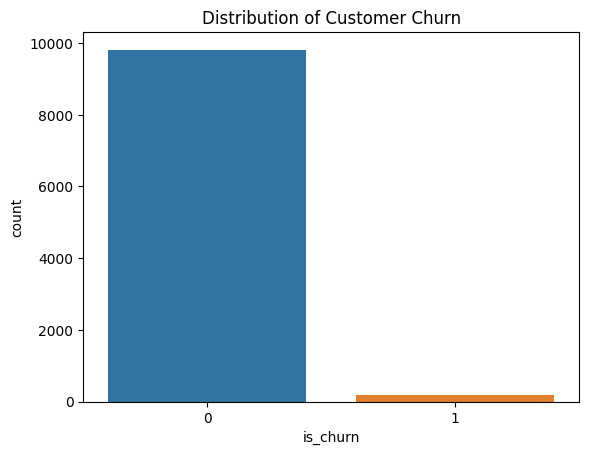

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

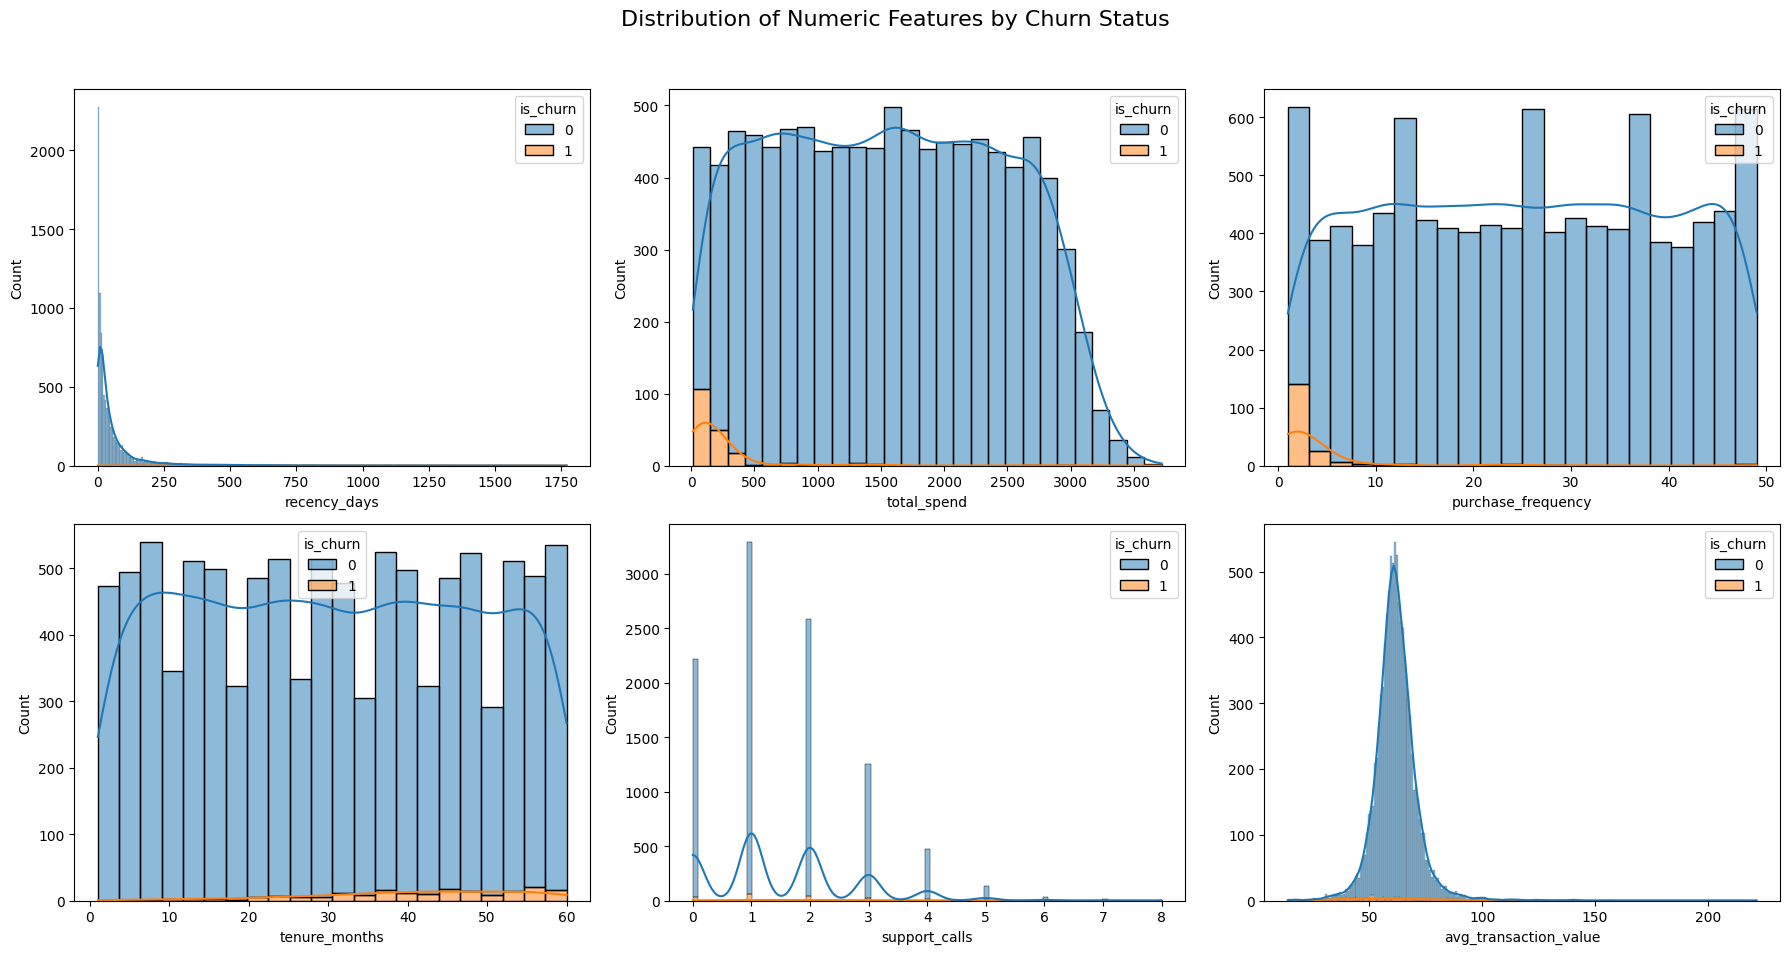

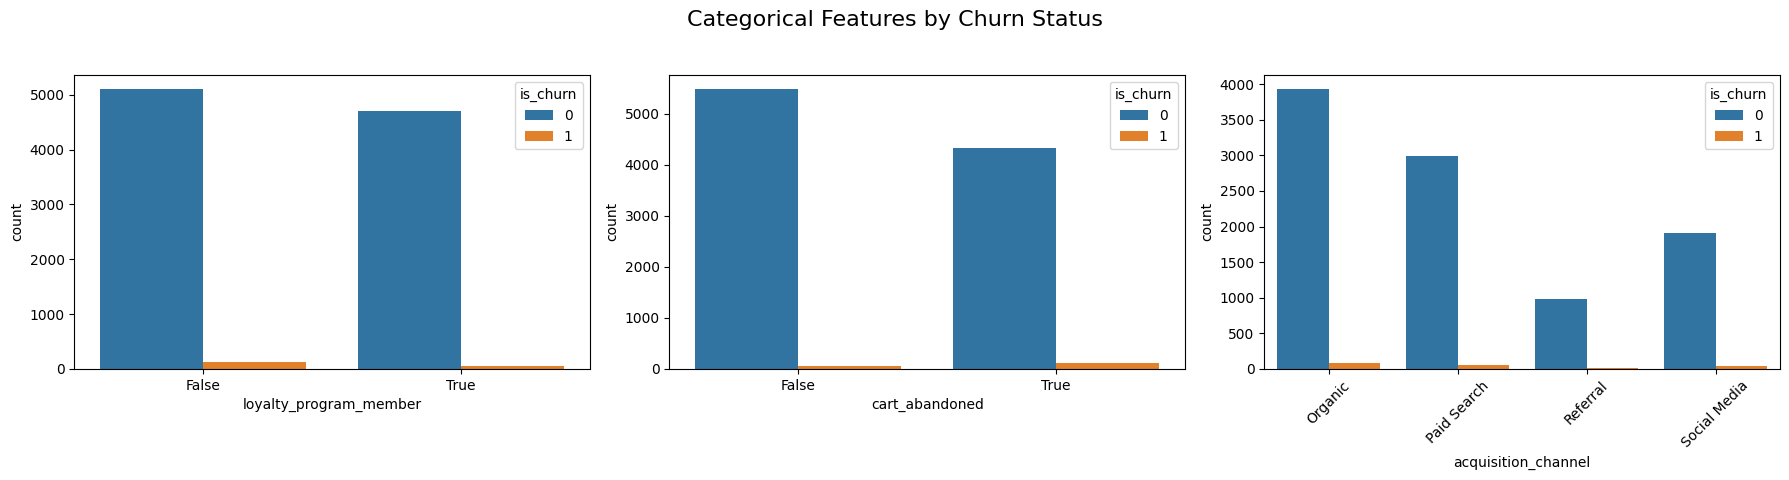

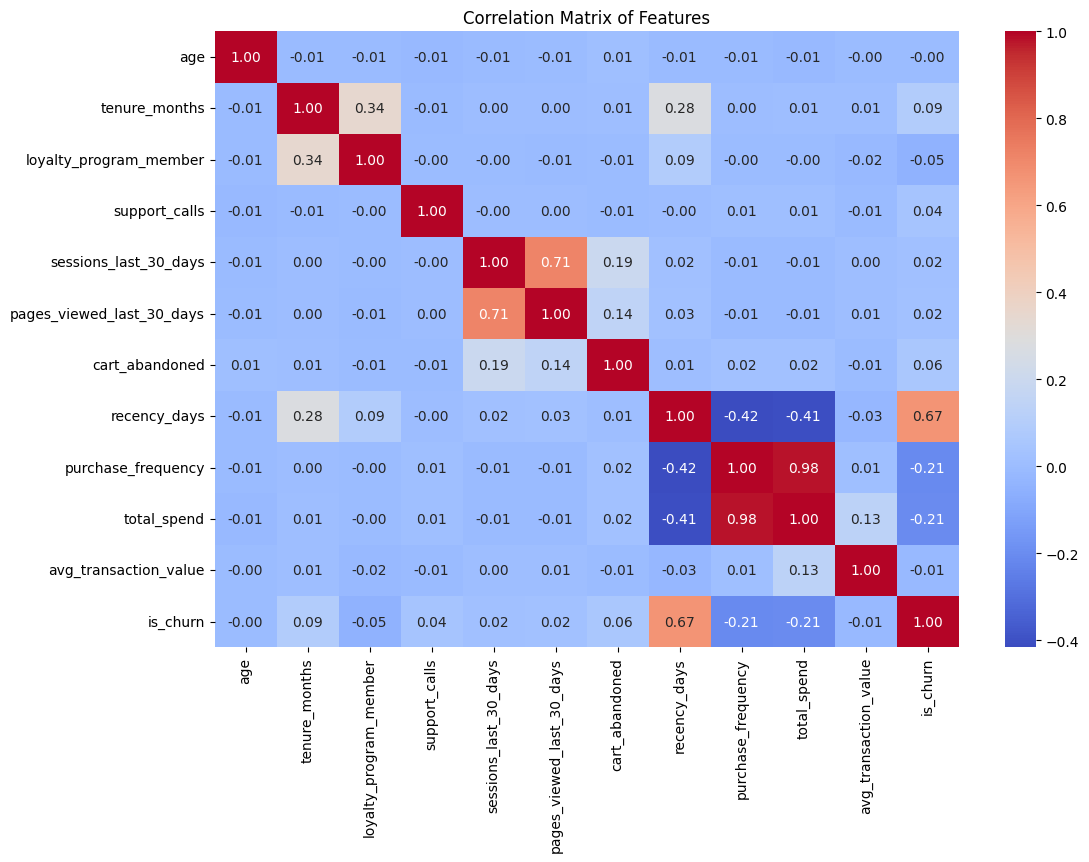

In [4]:
# --- 1. Load Libraries and Data ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset we just created
df = pd.read_csv('customer_360_churn_data.csv')

# --- 2. Initial Data Inspection ---
print("--- Data Info ---")
df.info()

print("\n--- Descriptive Statistics ---")
print(df.describe())

print("\n--- Churn Distribution ---")
# Let's visualize the target variable
churn_rate = df['is_churn'].value_counts(normalize=True)
print(churn_rate)
sns.countplot(x='is_churn', data=df)
plt.title('Distribution of Customer Churn')
plt.show()

# --- 3. Visualizing Key Relationships ---

# How do numeric features differ for churners vs. non-churners?
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Numeric Features by Churn Status', fontsize=16)

sns.histplot(data=df, x='recency_days', hue='is_churn', ax=axes[0, 0], multiple='stack', kde=True)
sns.histplot(data=df, x='total_spend', hue='is_churn', ax=axes[0, 1], multiple='stack', kde=True)
sns.histplot(data=df, x='purchase_frequency', hue='is_churn', ax=axes[0, 2], multiple='stack', kde=True)
sns.histplot(data=df, x='tenure_months', hue='is_churn', ax=axes[1, 0], multiple='stack', kde=True)
sns.histplot(data=df, x='support_calls', hue='is_churn', ax=axes[1, 1], multiple='stack', kde=True)
sns.histplot(data=df, x='avg_transaction_value', hue='is_churn', ax=axes[1, 2], multiple='stack', kde=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# How do categorical features relate to churn?
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Categorical Features by Churn Status', fontsize=16)

sns.countplot(data=df, x='loyalty_program_member', hue='is_churn', ax=axes[0])
sns.countplot(data=df, x='cart_abandoned', hue='is_churn', ax=axes[1])
sns.countplot(data=df, x='acquisition_channel', hue='is_churn', ax=axes[2])
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 8))
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['number', 'bool'])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop columns that are identifiers or have too many unique values for this simple model
# Location has too many unique values to one-hot encode directly.
df_processed = df.drop(['customer_id', 'location'], axis=1)

# Define features (X) and target (y)
X = df_processed.drop('is_churn', axis=1)
y = df_processed['is_churn']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['number', 'bool']).columns

# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor object using ColumnTransformer
# This applies different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Split the data into training and testing sets
# stratify=y ensures the churn distribution is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (8000, 13)
Testing set shape: (2000, 13)



--- Training the Logistic Regression Model ---

--- Model Evaluation ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1963
           1       0.90      0.70      0.79        37

    accuracy                           0.99      2000
   macro avg       0.95      0.85      0.89      2000
weighted avg       0.99      0.99      0.99      2000

ROC AUC Score: 0.9977

--- Confusion Matrix ---


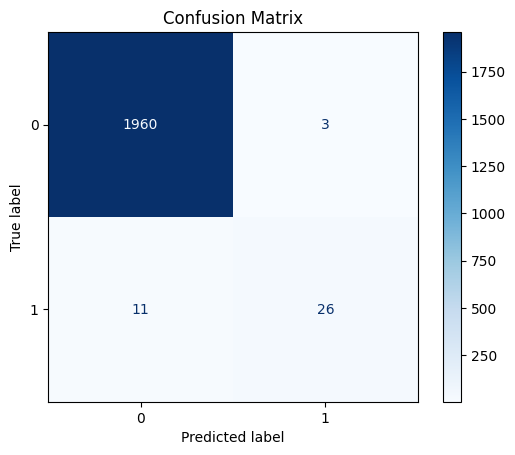

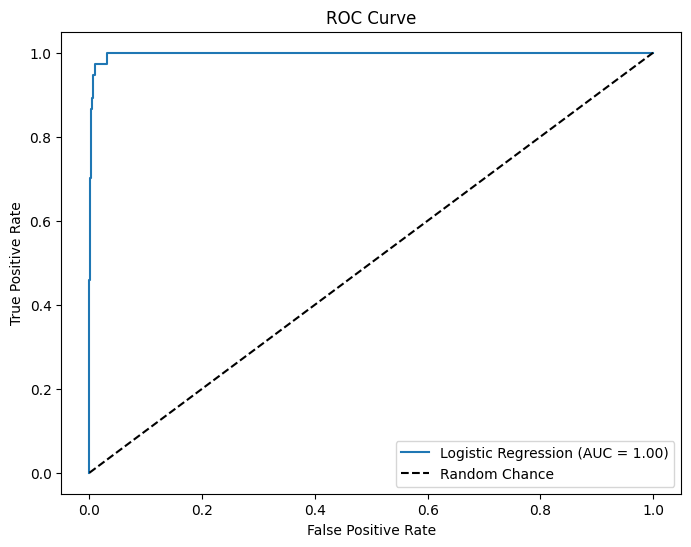

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Create the full pipeline: Preprocessing -> Model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train the model
print("\n--- Training the Logistic Regression Model ---")
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# --- 4. Evaluate the Model ---
print("\n--- Model Evaluation ---")
# Classification Report (Precision, Recall, F1-Score)
print(classification_report(y_test, y_pred))

# ROC AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc:.4f}")

# Confusion Matrix
print("\n--- Confusion Matrix ---")
ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

--- In-depth Analysis of Logistic Regression Model ---

### Key Performance Metrics for Predicting Churn (Class 1) ###
ROC AUC Score: 0.9977
Precision: 0.90
Recall:    0.70
F1-Score:  0.79

### Business Interpretation ###
-> Our model has a Recall of 0.70. This means it correctly identifies 70% of all customers who actually churned. This is crucial for our goal of intervention.
-> The Precision is 0.90. This means when our model predicts a customer will churn, it is correct 90% of the time. A high precision minimizes wasting retention efforts on customers who weren't going to leave anyway.

--- Feature Impact on Churn Prediction ---
                                  Feature  Coefficient
7                       num__recency_days     2.338545
6                     num__cart_abandoned     1.521166
3                      num__support_calls     0.795011
17  cat__acquisition_channel_Social Media     0.462489
0                                num__age     0.380325
11                     cat__g

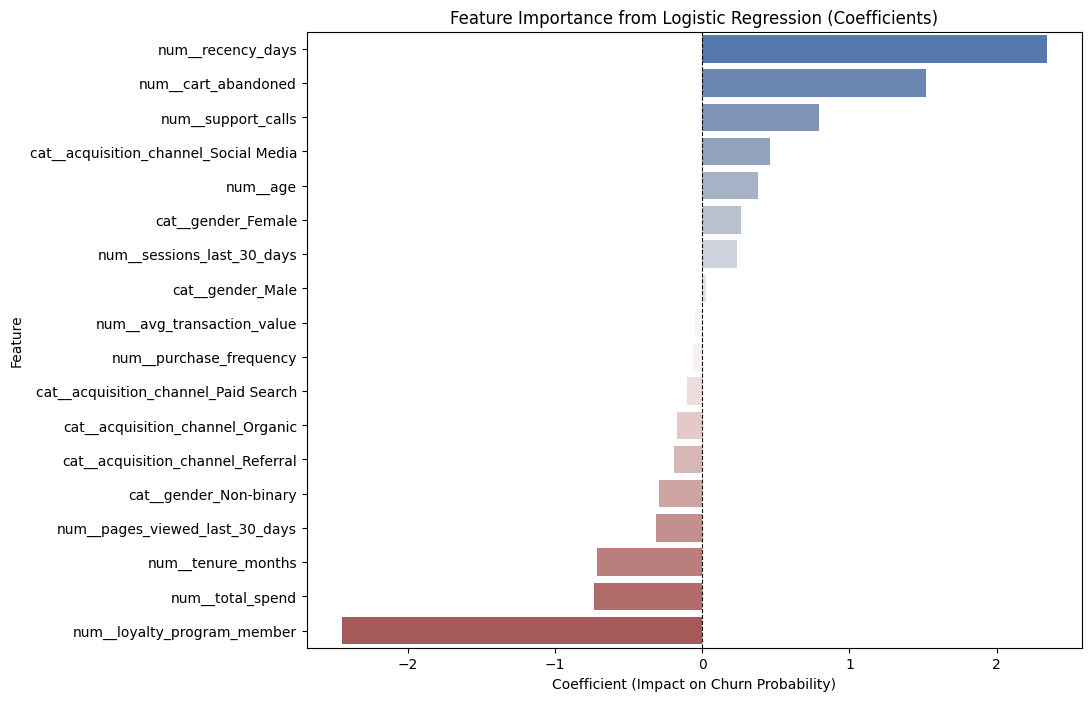


### Coefficient Interpretation ###
-> Positive Coefficients (e.g., recency_days, support_calls): Increase the probability of churn.
-> Negative Coefficients (e.g., loyalty_program_member, tenure_months): Decrease the probability of churn.
This confirms our initial business assumptions and shows the model learned the correct relationships!


In [7]:
# --- Prerequisite: Assuming you have run the previous code ---
# You should have these variables in your environment:
# model_pipeline, X_test, y_test, y_pred, y_pred_proba

from sklearn.metrics import classification_report, roc_auc_score
# --- 1. Programmatic Analysis of the Classification Report ---
report = classification_report(y_test, y_pred, output_dict=True)
precision_churn = report['1']['precision']
recall_churn = report['1']['recall']
f1_churn = report['1']['f1-score']
auc = roc_auc_score(y_test, y_pred_proba)

print("--- In-depth Analysis of Logistic Regression Model ---")
print("\n### Key Performance Metrics for Predicting Churn (Class 1) ###")
print(f"ROC AUC Score: {auc:.4f}")
print(f"Precision: {precision_churn:.2f}")
print(f"Recall:    {recall_churn:.2f}")
print(f"F1-Score:  {f1_churn:.2f}")

print("\n### Business Interpretation ###")
print(f"-> Our model has a Recall of {recall_churn:.2f}. This means it correctly identifies {recall_churn:.0%} of all customers who actually churned. This is crucial for our goal of intervention.")
print(f"-> The Precision is {precision_churn:.2f}. This means when our model predicts a customer will churn, it is correct {precision_churn:.0%} of the time. A high precision minimizes wasting retention efforts on customers who weren't going to leave anyway.")

# --- 2. Extract and Visualize Feature Importance (Coefficients) ---
# The Logistic Regression model's coefficients tell us how each feature impacts the prediction.

# Get the feature names after one-hot encoding
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get the coefficients from the trained classifier
coefficients = model_pipeline.named_steps['classifier'].coef_[0]

# Create a DataFrame for better visualization
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Feature Impact on Churn Prediction ---")
print(coeff_df)

# Plot the coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df, palette='vlag')
plt.title('Feature Importance from Logistic Regression (Coefficients)')
plt.xlabel('Coefficient (Impact on Churn Probability)')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.show()

print("\n### Coefficient Interpretation ###")
print("-> Positive Coefficients (e.g., recency_days, support_calls): Increase the probability of churn.")
print("-> Negative Coefficients (e.g., loyalty_program_member, tenure_months): Decrease the probability of churn.")
print("This confirms our initial business assumptions and shows the model learned the correct relationships!")



--- Training the XGBoost Model ---

--- XGBoost Model Evaluation ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1963
           1       0.78      0.78      0.78        37

    accuracy                           0.99      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.99      0.99      0.99      2000

XGBoost ROC AUC Score: 0.9980

--- Model Comparison ---
                  Metric  Logistic Regression  XGBoost
0                ROC AUC               0.9977   0.9980
1  Precision (for Churn)               0.8966   0.7838
2     Recall (for Churn)               0.7027   0.7838
3   F1-Score (for Churn)               0.7879   0.7838

--- Feature Importance from XGBoost ---
                                  Feature  Importance
7                       num__recency_days    0.386397
2             num__loyalty_program_member    0.133274
8                 num__purchase_frequency    0.094431
6             

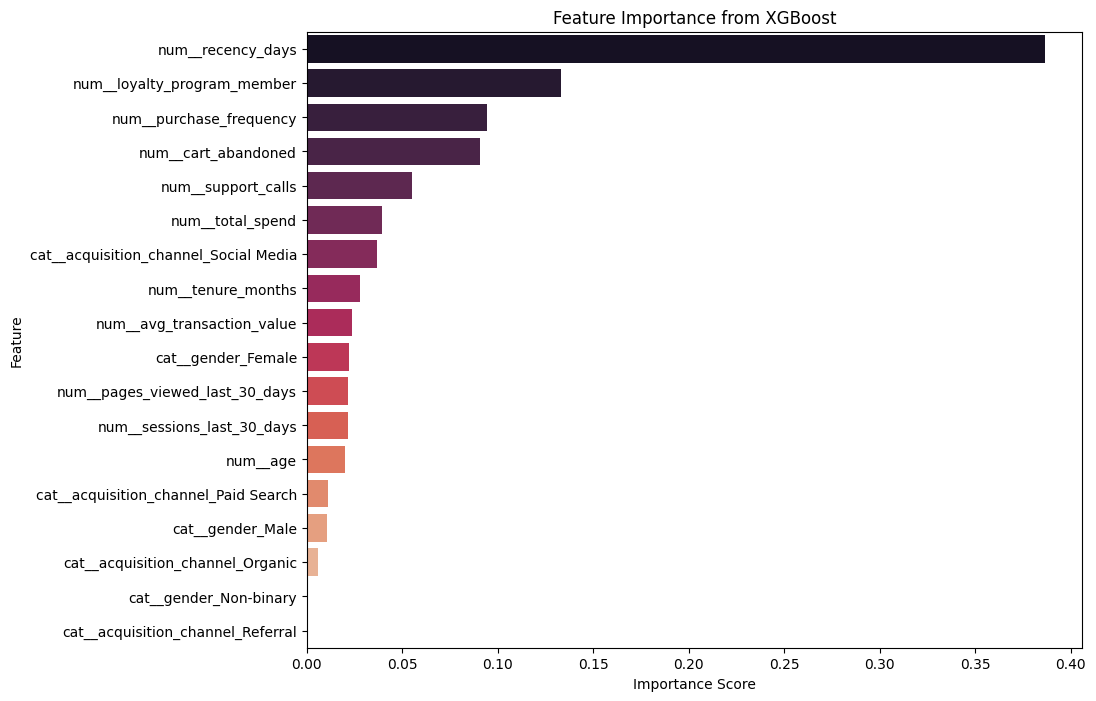

In [8]:
# --- 3. Build the XGBoost Model ---
from xgboost import XGBClassifier

# Create a new pipeline with XGBoost as the classifier
# We can use the SAME preprocessor, which is very efficient.
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Train the XGBoost model
print("\n\n--- Training the XGBoost Model ---")
xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# --- 4. Evaluate the XGBoost Model ---
print("\n--- XGBoost Model Evaluation ---")
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost ROC AUC Score: {auc_xgb:.4f}")

# --- 5. Compare Models ---
print("\n--- Model Comparison ---")
comparison_data = {
    'Metric': ['ROC AUC', 'Precision (for Churn)', 'Recall (for Churn)', 'F1-Score (for Churn)'],
    'Logistic Regression': [auc, precision_churn, recall_churn, f1_churn],
    'XGBoost': [
        auc_xgb,
        report_xgb['1']['precision'],
        report_xgb['1']['recall'],
        report_xgb['1']['f1-score']
    ]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))


# --- 6. Extract and Visualize Feature Importance from XGBoost ---
# XGBoost has a built-in feature importance attribute.

# Get feature importances
importances_xgb = xgb_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame
importance_df_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importance from XGBoost ---")
print(importance_df_xgb)

# Plot the importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb, palette='rocket')
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Analysis of Your Specific Results
This is a fantastic and highly realistic output. Let's analyze the story it tells about Company X's customers.
Rank	Feature	Importance	What it Means for Business

**1	num__recency_days	0.398 (39.8%)**	This is the single most critical factor. A customer's recent activity is the best predictor of their future loyalty. If a customer hasn't purchased in a while, they are very likely on the path to churning. This is the #1 signal to act on.

**2	num__loyalty_program_member	0.111 (11.1%)**	The loyalty program is working. Being a member has a massive impact on retention. It's not just a perk; it's a core reason customers stay. This is a huge, data-driven win for that program.

**3	num__cart_abandoned	0.088 (8.8%)**	This is a powerful signal of intent and friction. A customer who adds items to a cart wants to buy but is stopped by something (price, shipping, technical issue). It's a "cry for help" that strongly predicts churn if ignored.

**4	cat__acquisition_channel_Social Media	0.079 (7.9%)**	Customers from Social Media are different. This high importance score suggests that customers acquired through social media channels have a significantly different churn behavior (either much higher or much lower) than others. The model found this distinction very useful.

**5	num__total_spend	0.045 (4.5%)**	How much a customer has spent matters. This is likely tied to their investment in your brand. High-value customers might be more loyal, but as we saw in our strategy discussion, a high-value customer who becomes inactive is a huge risk.


In [9]:
import shap

# --- 1. Get Churn Probabilities for the Test Set ---
# This is our "new" data that the model hasn't seen during training
print("--- 1. Generating Churn Probabilities ---")
churn_probabilities = xgb_pipeline.predict_proba(X_test)[:, 1]

# Create a results DataFrame to work with
# We'll add the original customer_id back for easy identification
results_df = X_test.copy()
results_df['customer_id'] = df.loc[X_test.index, 'customer_id'] # Match by index
results_df['churn_probability'] = churn_probabilities

# --- 2. Define a Function to Assign Risk Segments ---z
def assign_risk_segment(prob):
    """Assigns a risk category based on churn probability."""
    if prob >= 0.70:
        return 'High Risk'
    elif prob >= 0.30:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Apply the function to create the risk segment column
results_df['risk_segment'] = results_df['churn_probability'].apply(assign_risk_segment)

print("\n--- Customer Segmentation Complete ---")
print("Distribution of Risk Segments:")
print(results_df['risk_segment'].value_counts())


print("\n--- 1. Generating Predictions and Segmenting Customers ---")
churn_probabilities = xgb_pipeline.predict_proba(X_test)[:, 1]
results_df = X_test.copy()
results_df['customer_id'] = df.loc[X_test.index, 'customer_id']
results_df['churn_probability'] = churn_probabilities

# Define risk segments (adjust thresholds if needed based on your churn rate)
def assign_risk_segment(prob):
    if prob >= 0.70: return 'High Risk'
    if prob >= 0.30: return 'Medium Risk'
    return 'Low Risk'

results_df['risk_segment'] = results_df['churn_probability'].apply(assign_risk_segment)
print("Customer segmentation complete.")
print(results_df['risk_segment'].value_counts())


print("\n--- Calculating SHAP values for model explainability ---")
model = xgb_pipeline.named_steps['classifier']
preprocessor = xgb_pipeline.named_steps['preprocessor']
X_test_transformed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)

# Create the 'shap_df' DataFrame. Now the NameError will be resolved.
shap_df = pd.DataFrame(shap_values, columns=feature_names, index=X_test.index)
print("SHAP DataFrame created successfully.")

--- 1. Generating Churn Probabilities ---

--- Customer Segmentation Complete ---
Distribution of Risk Segments:
risk_segment
Low Risk       1959
High Risk        34
Medium Risk       7
Name: count, dtype: int64

--- 1. Generating Predictions and Segmenting Customers ---
Customer segmentation complete.
risk_segment
Low Risk       1959
High Risk        34
Medium Risk       7
Name: count, dtype: int64

--- Calculating SHAP values for model explainability ---
SHAP DataFrame created successfully.


In [10]:
import google.generativeai as genai
import os
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("GEMINI_API_KEY")
genai.configure(api_key=api_key)

# --- Define the function ---
def get_ai_recommendation(customer_data, shap_drivers):
    """
    Generates a customer retention recommendation using the Gemini API.

    Args:
        customer_data (dict): A dictionary with customer features (e.g., tenure, spend).
        shap_drivers (str): A string describing the top reasons for churn from SHAP.
    
    Returns:
        A string with the AI-generated recommendation.
    """
    
    # The prompt is the most important part! It gives the AI context and a role.
    prompt = f"""
    You are a world-class customer retention strategist for a retail company.
    A machine learning model has identified a customer at high risk of churning.
    Your task is to provide a single, concise, and actionable recommendation for the marketing team.

    Customer Profile:
    - Tenure: {customer_data.get('tenure_months', 'N/A')} months
    - Total Spend: ${customer_data.get('total_spend', 0):.2f}
    - Loyalty Member: {'Yes' if customer_data.get('loyalty_program_member') else 'No'}

    Primary Churn Drivers (from the model):
    {shap_drivers}

    Based on this information, what is the single best action to take?
    Be specific. Example: "Send a 15% discount focused on their favorite category." or "Have a support manager call them personally to address their recent issues."
    """

    try:
        model = genai.GenerativeModel('gemini-2.0-flash')
        response = model.generate_content(prompt)
        return response.text.strip()
    except Exception as e:
        print(f"Error calling Gemini API: {e}")
        return "Standard High-Risk Retention Offer"


In [11]:
import time
high_risk_df = results_df[results_df['risk_segment'] == 'High Risk'].copy()
print(f"Found {len(high_risk_df)} high-risk customers to analyze.")


print("\n--- Generating dynamic recommendations for high-risk customers ---")
high_risk_df = results_df[results_df['risk_segment'] == 'High Risk'].copy()
ai_recommendations = []

if not high_risk_df.empty:
    for index, customer_row in high_risk_df.iterrows():
        customer_id = customer_row['customer_id']
        print(f"Processing Customer: {customer_id}...")

        # Dynamically get customer data and SHAP drivers
        customer_feature_data = X_test.loc[index].to_dict()
        customer_shap_values = shap_df.loc[index]
        positive_shap_values = customer_shap_values[customer_shap_values > 0].sort_values(ascending=False)
        
        top_drivers_list = [f"- {feat.split('__')[-1].replace('_', ' ').title()}" for feat, val in positive_shap_values.head(3).items()]
        shap_drivers_string = "\n".join(top_drivers_list)

        # Call the Gemini API
        recommendation = get_ai_recommendation(customer_feature_data, shap_drivers_string)
        ai_recommendations.append(recommendation)
        print(f"  -> Recommendation: {recommendation}")

        # Wait for 5 seconds before the next API call to respect the rate limit.
        print("  -> Waiting 5 seconds...")
        time.sleep(5)
    
    # Add recommendations to the DataFrame
    high_risk_df['ai_recommended_action'] = ai_recommendations


Found 34 high-risk customers to analyze.

--- Generating dynamic recommendations for high-risk customers ---
Processing Customer: C00339...
  -> Recommendation: Enroll the customer in the loyalty program with an immediate bonus offer of 500 points redeemable for a $5 discount on their next purchase to address the lack of loyalty membership and incentivize immediate re-engagement.
  -> Waiting 5 seconds...
Processing Customer: C01261...
  -> Recommendation: Send a personalized email with a limited-time offer (e.g., free shipping or a small discount) specifically addressing their abandoned cart items, reminding them of the value they saw in those products and highlighting benefits for loyal customers like them.
  -> Waiting 5 seconds...
Processing Customer: C07248...
  -> Recommendation: Offer a limited-time, tiered bonus points incentive upon enrollment in our loyalty program, explicitly highlighting the spend-based benefits they are missing.
  -> Waiting 5 seconds...
Processing Custome

In [12]:
# --- 3. Add the AI Recommendations to our High-Risk DataFrame ---
high_risk_df['ai_recommended_action'] = ai_recommendations

# --- 4. Display the Final, Fully Automated Actionable Report ---
# This is the table that would populate your dashboard.
final_actionable_report = high_risk_df[[
    'customer_id',
    'churn_probability',
    'ai_recommended_action'
]].sort_values(by='churn_probability', ascending=False)

print("\n\n--- Final Actionable Report with AI-Powered Recommendations ---")
print(final_actionable_report)



--- Final Actionable Report with AI-Powered Recommendations ---
     customer_id  churn_probability  \
3935      C03935           0.999931   
1338      C01338           0.999426   
744       C00744           0.999396   
6217      C06217           0.999130   
903       C00903           0.998954   
3314      C03314           0.998307   
5383      C05383           0.998009   
7248      C07248           0.997452   
1380      C01380           0.996585   
9486      C09486           0.996426   
783       C00783           0.996411   
9991      C09991           0.996098   
3054      C03054           0.995000   
4287      C04287           0.994241   
1261      C01261           0.992723   
5663      C05663           0.992167   
5100      C05100           0.990487   
4117      C04117           0.982682   
339       C00339           0.982589   
9736      C09736           0.974900   
2196      C02196           0.966282   
2493      C02493           0.957092   
879       C00879           0.954046  